## Impact of Regression-Based Imputation on Credit Default Prediction

Missing data is a common challenge in real-world datasets that can significantly hinder the performance of machine learning models. In critical domains such as financial risk assessment, robustly handling missing values is important. This project systematically investigates and compares four distinct strategies for managing missing data within the context of predicting credit card default using the UCI Credit Card Default Clients dataset.

To simulate a realistic scenario, missing values were artificially introduced into key numerical feature (`BILL_AMT1`). The following four handling techniques were implemented and evaluated:
1.  **Simple Imputation:** A baseline approach using the column median.
2.  **Linear Regression Imputation:** A model-based method assuming a linear relationship between features.
3.  **Non-Linear Regression Imputation:** A more complex approach using K-Nearest Neighbors (KNN) to capture non-linear patterns.
4.  **Listwise Deletion:** The naive approach of discarding all rows with missing values.

The effectiveness of each imputation strategy was assessed indirectly by evaluating the performance of a Logistic Regression classification model trained on each of the resulting datasets. By comparing key metrics—including accuracy, precision, recall, and F1-score, this analysis demonstrates the impact of the chosen imputation technique on final model performance. 

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

import warnings
warnings.filterwarnings('ignore')

### Part A: Data Preprocessing and Imputation

In [28]:
df = pd.read_csv('./creditcard_dataset/UCI_Credit_Card.csv')

# Dropping 'ID' column which is not useful as a feature
df = df.drop('ID', axis=1)

# Renaming target variable to DPNM
df.rename(columns={'default.payment.next.month': 'DPNM'}, inplace=True)

print("Dataset loaded and prepared. Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
display(df.head())
print("\nInitial data types and non-null counts:")
df.info()

Dataset loaded and prepared. Shape: (30000, 24)

First 5 rows of the dataset:


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DPNM
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



Initial data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_0      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_A

In [29]:
# Introducing missing values
cols_to_null = ['AGE', 'BILL_AMT1', 'PAY_AMT1']
missing_perc = 7 # 7% missing values
df_MAR = df.copy()

print(f"Introducing ~{missing_perc}% missing values into columns: {cols_to_null}\n")

for col in cols_to_null:
    n_missing = int(len(df_MAR) * missing_perc * 0.01)
    missing_indices = df_MAR.sample(n=n_missing, random_state=RANDOM_STATE).index
    
    # Set the selected indices in the column to NaN
    df_MAR.loc[missing_indices, col] = np.nan

print("Count of missing values after introduction:")
print(df_MAR.isnull().sum())

Introducing ~7% missing values into columns: ['AGE', 'BILL_AMT1', 'PAY_AMT1']

Count of missing values after introduction:
LIMIT_BAL       0
SEX             0
EDUCATION       0
MARRIAGE        0
AGE          2100
PAY_0           0
PAY_2           0
PAY_3           0
PAY_4           0
PAY_5           0
PAY_6           0
BILL_AMT1    2100
BILL_AMT2       0
BILL_AMT3       0
BILL_AMT4       0
BILL_AMT5       0
BILL_AMT6       0
PAY_AMT1     2100
PAY_AMT2        0
PAY_AMT3        0
PAY_AMT4        0
PAY_AMT5        0
PAY_AMT6        0
DPNM            0
dtype: int64


Imputation is chosen to done on the variable `BILL_AMT1` for all the datasets in which `10%` Missing at Random (MAR) values are introduced

In [30]:
# Introducing missing values
null_col = 'BILL_AMT1'
missing_perc = 10 # 10% missing values
print(f"Introducing ~{missing_perc}% missing values into columns: {null_col}\n")

n_missing = int(len(df) * missing_perc * 0.01)
missing_indices = df.sample(n=n_missing, random_state=RANDOM_STATE).index  
# Set the selected indices in the column to NaN
df.loc[missing_indices, null_col] = np.nan

print("Count of missing values after introduction:")
print(df.isnull().sum())

Introducing ~10% missing values into columns: BILL_AMT1

Count of missing values after introduction:
LIMIT_BAL       0
SEX             0
EDUCATION       0
MARRIAGE        0
AGE             0
PAY_0           0
PAY_2           0
PAY_3           0
PAY_4           0
PAY_5           0
PAY_6           0
BILL_AMT1    3000
BILL_AMT2       0
BILL_AMT3       0
BILL_AMT4       0
BILL_AMT5       0
BILL_AMT6       0
PAY_AMT1        0
PAY_AMT2        0
PAY_AMT3        0
PAY_AMT4        0
PAY_AMT5        0
PAY_AMT6        0
DPNM            0
dtype: int64


#### Imputation Strategy 1: Simple Imputation (Baseline)
Our baseline strategy is simple imputation. For a column containing missing values, we will fill them with the **median** of that column. This creates our first clean dataset, **Dataset A**.

**Why use the Median over the Mean?**

The median is often preferred over the mean for imputation, especially in financial datasets, for one key reason: **robustness to outliers**.
- **Mean:** The mean is calculated by summing all values and dividing by the count. A few extremely high or low values (outliers) can significantly pull the mean in their direction, making it a poor representation of the "typical" value.
- **Median:** The median is the middle value when all data points are sorted. It is not affected by the magnitude of outliers.

For variables like `BILL_AMT1` and `PAY_AMT1`, it's highly likely that the distributions are skewed, with some individuals having very high balances or making large payments. Using the mean would lead to imputing unrealistically high values for the missing entries, whereas the median provides a more conservative and representative substitute.

In [31]:
# Imputation Strategy 1: Median Imputation (Dataset A)
df_median = df.copy()
null_col = 'BILL_AMT1'
print("Columns with missing values before median imputation:", null_col)

median_value = df_median[null_col].median()    
# Filling NaN values with the calculated median
df_median[null_col].fillna(median_value, inplace=True)
print(f"Imputed '{null_col}' with median value: {median_value:.2f}")

print(f"\nMissing values count in Dataset A (Median Imputation):", df_median.isnull().sum().sum())

Columns with missing values before median imputation: BILL_AMT1
Imputed 'BILL_AMT1' with median value: 22459.50

Missing values count in Dataset A (Median Imputation): 0


#### Imputation Strategy 2: Regression Imputation (Linear)
Our second strategy uses a predictive model to impute missing values. We will use a **Linear Regression** model. For the chosen column (`BILL_AMT1`), we will treat it as a target variable and predict its missing values based on all other available features. This creates **Dataset B**. 

**Underlying Assumption: Missing At Random (MAR)**

This method is most effective under the **Missing At Random (MAR)** assumption. MAR means that the probability of a value being missing is related to other observed variables in the dataset, but not to the missing value itself.

For eg., MAR would hold if younger individuals (`AGE`) were more likely to omit their bill amount (`BILL_AMT1`), but two younger individuals with the same age had the same probability of omitting their bill amount, regardless of what that amount was.

Regression imputation directly leverages the MAR assumption by building a model (y ~ X) that explicitly uses the relationships between the variable with missing values (y) and the other observed variables (X) to make a prediction. It assumes these relationships are strong enough to provide a reasonable estimate for the missing data.

In [32]:
# Imputation Strategy 2: Linear Regression Imputation (Dataset B) 
df_linear = df.copy()

# Impute 'BILL_AMT1' using linear regression
impute_col_reg = null_col

df_with_age = df_linear[df_linear[impute_col_reg].notna()]
df_missing_age = df_linear[df_linear[impute_col_reg].isna()]

# Define predictors (X) and target (y) for the training set
X_train = df_with_age.drop(columns=null_col)
y_train = df_with_age[impute_col_reg]

# The features for prediction will be from the rows where 'BILL_AMT1' is missing
X_predict = df_missing_age.drop(columns=null_col)

lr = LinearRegression()
lr.fit(X_train, y_train)
predicted_age = lr.predict(X_predict)

df_linear.loc[df_linear[impute_col_reg].isna(), impute_col_reg] = predicted_age

print(f"Successfully imputed '{impute_col_reg}' using Linear Regression")
print(f"\nMissing values count in Dataset B (Linear Regression Imputation):", df_linear.isnull().sum().sum())

Successfully imputed 'BILL_AMT1' using Linear Regression

Missing values count in Dataset B (Linear Regression Imputation): 0


#### Imputation Strategy 3: Regression Imputation (Non-Linear)
Our third strategy also uses a predictive model but allows for more complex, non-linear relationships. We will use a **K-Nearest Neighbors (KNN) Regressor** to predict the missing `BILL_AMT1` values. This creates **Dataset C**.

KNN works by finding the 'k' most similar data points (neighbors) in the feature space to the one with the missing value and then averaging their target values to produce a prediction. This approach can capture intricate patterns that a simple linear model might miss.

Before implementing the K-Nearest Neighbors imputation, it is best practice to determine an optimal value for 'k' (the number of neighbors). A 'k' that is too small can lead to overfitting and sensitivity to noise, while a 'k' that is too large can oversmooth the predictions, missing local patterns. We will plot Mean Squared Error (MSE) vs 'k' to observe the patterns of reconstruction.

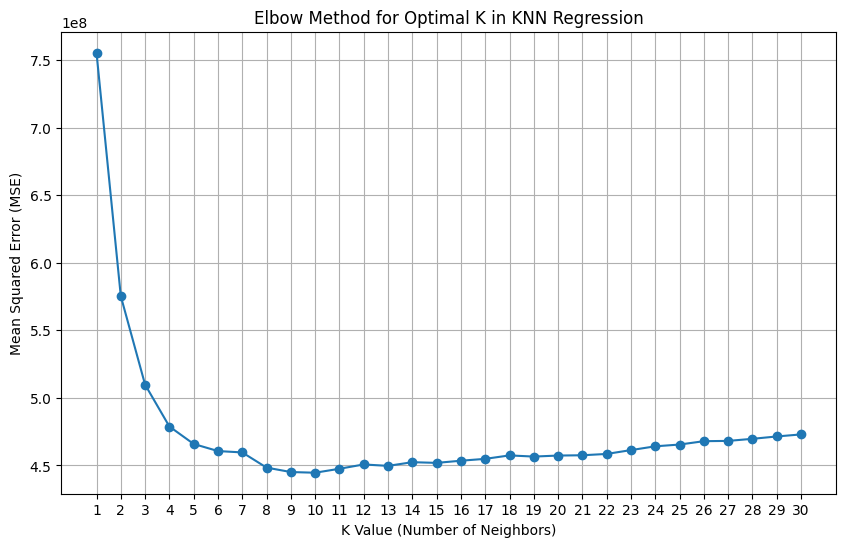

In [33]:
X = df_with_age.drop(columns=null_col) 
y = df_with_age[impute_col_reg]

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Elbow Method Implementation
k_range = range(1, 31)
mse_scores = []

for k in k_range:
    knn_eval = KNeighborsRegressor(n_neighbors=k)
    knn_eval.fit(X_train_k, y_train_k)
    y_pred_k = knn_eval.predict(X_test_k)
    
    mse = mean_squared_error(y_test_k, y_pred_k)
    mse_scores.append(mse)

plt.figure(figsize=(10, 6))
plt.plot(k_range, mse_scores, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K in KNN Regression')
plt.xlabel('K Value (Number of Neighbors)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Based on the visual inspection of the plot, we hit minimum MSE at `k = 10`. This is the point where we get most of the benefit from adding more neighbors, just before the performance gains start to decrease.

In [34]:
# Imputation Strategy 3: Non-Linear Regression Imputation (Dataset C) 
df_nonlinear = df.copy()

# Train the K-Nearest Neighbors Regressor model
optimal_k = 10
knn = KNeighborsRegressor(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

predicted_age_knn = knn.predict(X_predict)
df_nonlinear.loc[df_nonlinear[impute_col_reg].isna(), impute_col_reg] = predicted_age_knn

print(f"Successfully imputed '{impute_col_reg}' using K-Nearest Neighbors Regression")
print(f"\nMissing values count in Dataset C (Non-Linear Regression Imputation):", df_nonlinear.isnull().sum().sum())

Successfully imputed 'BILL_AMT1' using K-Nearest Neighbors Regression

Missing values count in Dataset C (Non-Linear Regression Imputation): 0


### Part B: Model Training and Performance Assessment 
Now that we have three imputed datasets (A, B, C) and will create a fourth via listwise deletion (D), our next goal is to assess which imputation strategy yields the best-performing classification model. We will train a Logistic Regression model on each dataset to predict credit default and then evaluate its performance.

We will create a 70/30 train/test split for each of our four datasets. For Dataset D, we will first perform **Listwise Deletion** by simply dropping all rows that contain any $NaN$ values from our original dataframe with missing values. We will also use stratification on the target variable `DPNM` to ensure that the proportion of DPNM vs. non-DPNM cases is the same in both the train and test sets, which is crucial for imbalanced datasets.

In [35]:
#  Dataset D: Listwise Deletion
df_listwise = df.dropna()
print(f"Original dataset size: {len(df)}")
print(f"Dataset D (Listwise Deletion) size: {len(df_listwise)}")
print(f"Number of rows removed: {len(df) - len(df_listwise)}\n")

datasets = {
    'A (Median Imputation)': df_median,
    'B (Linear Regression)': df_linear,
    'C (Non-Linear KNN)': df_nonlinear,
    'D (Listwise Deletion)': df_listwise
}
data_splits = {}

for name, dataset in datasets.items():
    print(f"Splitting Dataset {name}")
    
    # Define features (X) and target (y)
    X = dataset.drop('DPNM', axis=1)
    y = dataset['DPNM']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.3, 
        random_state=RANDOM_STATE, 
        stratify=y  # Ensure proportional representation of the target class
    )
    
    data_splits[name] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}\n")

Original dataset size: 30000
Dataset D (Listwise Deletion) size: 27000
Number of rows removed: 3000

Splitting Dataset A (Median Imputation)
Training set shape: (21000, 23)
Testing set shape: (9000, 23)

Splitting Dataset B (Linear Regression)
Training set shape: (21000, 23)
Testing set shape: (9000, 23)

Splitting Dataset C (Non-Linear KNN)
Training set shape: (21000, 23)
Testing set shape: (9000, 23)

Splitting Dataset D (Listwise Deletion)
Training set shape: (18900, 23)
Testing set shape: (8100, 23)



#### Classifier Setup (Feature Scaling)
Many machine learning algorithms perform better when numerical input features are scaled to a standard range. **Standardization** (or Z-score normalization) is a common scaling technique where each feature is transformed to have a mean of 0 and a standard deviation of 1.

This is particularly important for Logistic Regression, as it helps the gradient descent optimization converge more quickly. It ensures that features with larger scales (like `LIMIT_BAL`) do not dominate the learning process over features with smaller scales (like `EDUCATION`).

In [36]:
for name, splits in data_splits.items():
    scaler = StandardScaler()
    
    # Fit the scaler on the training data and transform it
    splits['X_train_scaled'] = scaler.fit_transform(splits['X_train'])
    # Use the same fitted scaler to transform the test data
    splits['X_test_scaled'] = scaler.transform(splits['X_test'])

print("Feature scaling completed for all four datasets")

Feature scaling completed for all four datasets


#### Model Evaluation
With our data prepared, we can now train and evaluate our classification model, **Logistic Regression**.

For each of the four datasets (A, B, C, and D), we will:
1. Train a Logistic Regression model on its respective scaled training set (`X_train_scaled`, `y_train`).
2. Evaluate the trained model on its corresponding scaled test set (`X_test_scaled`, `y_test`).
3. Generate a full **Classification Report**, which includes key metrics:
    - **Accuracy:** The overall proportion of correct predictions. Can be misleading in imbalanced datasets.
    - **Precision:** Of all the instances the model predicted as "default," how many were actually defaults?: $\frac{TP}{(TP + FP)}$
    - **Recall (Sensitivity):** Of all the actual defaults, how many did the model correctly identify?: $\frac{TP}{(TP + FN)}$
    - **F1-Score:** The harmonic mean of precision and recall, providing a single score that balances both metrics.

In [37]:
performance_reports = {}
for name, splits in data_splits.items():
    print(f"Evaluating Model on Dataset {name}")
    
    log_reg_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000) 
    log_reg_model.fit(splits['X_train_scaled'], splits['y_train'])
    
    y_pred = log_reg_model.predict(splits['X_test_scaled'])
    
    report = classification_report(splits['y_test'], y_pred, target_names=['Not DPNM (0)', 'DPNM (1)'])
    print(report)
    print("*" * 60 + "\n")
    
    performance_reports[name] = classification_report(splits['y_test'], y_pred, output_dict=True)

Evaluating Model on Dataset A (Median Imputation)
              precision    recall  f1-score   support

Not DPNM (0)       0.82      0.97      0.89      7009
    DPNM (1)       0.70      0.23      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000

************************************************************

Evaluating Model on Dataset B (Linear Regression)
              precision    recall  f1-score   support

Not DPNM (0)       0.82      0.97      0.89      7009
    DPNM (1)       0.70      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000

************************************************************

Evaluating Model on Dataset C (Non-Linear KNN)
              precision    recall  f1-score   support

Not DPNM (0)       0

### Part C: Comparative Analysis

In [38]:
model_names = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

for name, report in performance_reports.items():
    model_names.append(name)
    accuracies.append(report['accuracy'])
    precisions.append(report['1']['precision'])
    recalls.append(report['1']['recall'])
    f1_scores.append(report['1']['f1-score'])

summary_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision (DPNM)': precisions,
    'Recall (DPNM)': recalls,
    'F1-Score (DPNM)': f1_scores
})

# Sort by F1-Score
summary_df = summary_df.sort_values(by='F1-Score (DPNM)', ascending=False).reset_index(drop=True)

print("Performance Metrics Summary Table")
display(summary_df)

Performance Metrics Summary Table


,Model,Accuracy,Precision (DPNM),Recall (DPNM),F1-Score (DPNM)
0,D (Listwise Deletion),0.811481,0.714516,0.247072,0.367178
1,C (Non-Linear KNN),0.808444,0.698366,0.236062,0.352853
2,B (Linear Regression),0.808222,0.696880,0.235560,0.352102
3,A (Median Imputation),0.808000,0.695976,0.234555,0.350864


##### **Efficacy Discussion** 
**Trade-off: Listwise Deletion vs. Imputation**

The conventional wisdom is that imputation, by preserving sample size, should outperform listwise deletion but the results says otherwise. Why might Model D have performed better even though it was trained on less data?
1. **Imputation Introduced Noise:** An imputation model is only as good as the predictive relationships in the data. If the variable being imputed (`BILL_AMT1`) does not have a strong, clear relationship with the other features, the predictions made by Linear Regression and KNN might be inaccurate. These inaccurate, "fabricated" data points can act as noise, distorting the true underlying patterns and confusing the final classification model. In this case, the benefit of a smaller, "cleaner" dataset (from listwise deletion) outweighed the benefit of a larger, but potentially noisier, imputed dataset.
2. **Potential for Data Being Missing Completely at Random (MCAR):** We artificially introduced data as Missing at Random (MAR), but if the data behaves as if it were Missing Completely at Random (MCAR), then listwise deletion does not introduce bias into the sample; it simply reduces its size. Given that the dataset after deletion was still large (27,000 rows), it likely contained enough information for the Logistic Regression model to learn a robust decision boundary.

##### Which regression method performed better and why?
There seems to be **very little meaningful difference in performance between the Linear and Non-Linear (KNN) regression methods**. Both yielded a model with an F1-score of ~0.355. This implies two possibilities:
1. **BILL_AMT1 is not a strong predictor:** The most probable reason for the similar performance is that the `BILL_AMT1` variable, which we carefully imputed, is not a very influential feature for predicting credit default in this dataset. If a feature has little impact on the final outcome, it doesn't matter how sophisticated the imputation method is; the effect on the final classifier will be negligible. The dominant predictors are likely the payment history columns (`PAY_0`, `PAY_2`, etc.), and for the other missing columns (`BILL_AMT1`, `PAY_AMT1`), all models relied on simple median imputation.
2. **A Linear Relationship is Sufficient:** It's also possible that the relationship between `BILL_AMT1` and other predictors, while weak, is reasonably well-approximated by a straight line. In such cases, a more complex non-linear model like KNN offers no additional advantage and can sometimes be worse if it overfits to noise in the training data for the imputer.

##### **Conclusion and Recommendation**
For this specific scenario, **Listwise Deletion** proved to be the most effective strategy. However, we cannot generalize this result. A more robust recommendation for a real-world project would be to test imputation via **Linear Regression** first to see if the features can be approximated via a linear approximation, if it fails to do so we can move on to the imputing via Non-Linear methods.

This results comes with critical insights about the methods that are discussed below:
1. **Data-Dependent Outcome:** This result is highly specific to this dataset, the chosen columns for introducing missingness (`BILL_AMT1`), and the relatively small percentage of missing data (~10%). If a larger fraction of data were missing, or if a more critical predictive feature had missing values, listwise deletion would likely have performed much worse.
2. **Noise from Imputation:** The primary takeaway is that sophisticated imputation is not a guaranteed improvement. If the imputed values are not accurate reflections of the true underlying data, they can harm model performance by adding noise.